<a href="https://colab.research.google.com/github/Andres8bit/Machine-Learning/blob/main/GoogleLeNet_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
import os
import sys
import cv2 
import numpy as np 
import keras
import math
from keras.datasets import cifar10
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, BatchNormalization, Activation
from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [160]:
# Dataset Download:
base_path = "/content/drive/MyDrive/bird Species.zip (Unzipped Files)"
train_path = os.path.join(base_path,'train')
test_path = os.path.join(base_path,'test')
validation_path = os.path.join(base_path,'valid')

In [161]:
def normalize_images(items):
  temp = np.zeros(shape=(items.shape))
  mean = np.mean(items,axis=(0,1,2,3))
  std = np.std(items,axis=(0,1,2,3))
  temp =(items - mean) /(std +1e-7)
  return temp

In [162]:
def display_loss(model):
  loss = model.history['loss']
  val_loss = model.history['val_loss']

  plt.figure()
  plt.plot(model.epoch, loss, 'r',label='Training loss')
  plt.plot(model.epoch,val_loss,'bo',label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss Value')
  plt.ylim([0,1])
  plt.legend()

In [163]:
(x_train,y_train), (x_test,y_test) = cifar10.load_data()

In [164]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [165]:
(x_train,x_valid) = x_train[5000:],x_train[:5000]
(y_train, y_valid) = y_train[5000:],y_train[:5000]

In [166]:
# One-Hot Encocding of lables:
y_train = np_utils.to_categorical(y_train,10)
y_valid = np_utils.to_categorical(y_valid,10)
y_test = np_utils.to_categorical(y_test,10)

In [167]:


# Data Augmentation:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=False
)

datagen.fit(x_train)



In [168]:
# Load Datasets to Tensorflow Dataset:
training_set = image_dataset_from_directory(directory=train_path,labels='inferred'
                                    ,label_mode='categorical', class_names=None,
                                    color_mode='rgb', batch_size=32,
                                    image_size=(224, 224),shuffle=True)
test_set = image_dataset_from_directory(test_path,labels='inferred',
                                    label_mode='categorical',class_names=None,
                                    color_mode='rgb',batch_size=32,shuffle=True
                                    ,image_size=(224,224))
valid_set = image_dataset_from_directory(validation_path,labels='inferred',
                                    label_mode='categorical',class_names=None,
                                    color_mode='rgb',shuffle=True,batch_size=32,
                                    image_size=(224,224))

Found 39364 files belonging to 275 classes.
Found 1375 files belonging to 275 classes.
Found 1375 files belonging to 275 classes.


In [169]:
# image_test_set = np.zeros(shape=(39364,224,224,3))
# label_test_seet = np.zeros(shape=(39364,1,275))
# for image_batch, labels_batch in training_set:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   images = image_batch.numpy()
#   labels = labels_batch.numpy()
#   print(images.shape)
#   print(labels.shape)
#   image_test_set = numpy.append(image_test_set,images,axis=0)
  


In [170]:
def split_set(set):
  labels = np.zeros(shape=(1,1,set.take(1)[1].shape[1]))
#

In [171]:
training_set.class_names

['AFRICAN CROWNED CRANE',
 'AFRICAN FIREFINCH',
 'ALBATROSS',
 'ALEXANDRINE PARAKEET',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'ANHINGA',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ARARIPE MANAKIN',
 'ASIAN CRESTED IBIS',
 'BALD EAGLE',
 'BALI STARLING',
 'BALTIMORE ORIOLE',
 'BANANAQUIT',
 'BANDED BROADBILL',
 'BAR-TAILED GODWIT',
 'BARN OWL',
 'BARN SWALLOW',
 'BARRED PUFFBIRD',
 'BAY-BREASTED WARBLER',
 'BEARDED BARBET',
 'BEARDED REEDLING',
 'BELTED KINGFISHER',
 'BIRD OF PARADISE',
 'BLACK & YELLOW bROADBILL',
 'BLACK FRANCOLIN',
 'BLACK SKIMMER',
 'BLACK SWAN',
 'BLACK TAIL CRAKE',
 'BLACK THROATED BUSHTIT',
 'BLACK THROATED WARBLER',
 'BLACK VULTURE',
 'BLACK-CAPPED CHICKADEE',
 'BLACK-NECKED GREBE',
 'BLACK-THROATED SPARROW',
 'BLACKBURNIAM WARBLER',
 'BLUE GROUSE',
 'BLUE HERON',
 'BOBOLINK',
 'BORNEAN BRISTLEHEAD',
 'BORNEAN LEAFBIRD',
 'BROWN NOODY',
 'BROWN THRASHER',
 'BULWERS

In [172]:
# Buffered Prefetching for better performance by overlaping model execution and data preprocessing:
AUTOTUNE = tf.data.AUTOTUNE

training_set = training_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)
valid_set = valid_set.cache().prefetch(buffer_size=AUTOTUNE)

In [173]:
def decay(epoch,steps=100):
  init_learning_rate = 0.01
  drop = 0.96
  epochs_drop = 8
  learning_rate = init_learning_rate * math.pow(drop,math.floor((1+epochs)/epochs_drop))
  return learning_rate

In [174]:
def inception_module(x,filters_1x1, filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool,name=None):
  # Functional API Layer Construction:
  conv_1x1 = Conv2D(filters=filters_1x1,kernel_size=(1,1),padding='same',
                    kernel_initializer=kernel_init,bias_initializer=bias_init)(x)
  
  # 3x3 route -> 1x1 reduce to 3x3 Convolution:
    #  1x1 Reduce/Bottleneck layer:
  pre_conv_3x3 = Conv2D(filters=filters_3x3_reduce,kernel_size=(1,1),
                        padding='same',activation='relu',
                        kernel_initializer=kernel_init,bias_initializer=bias_init)(x)
    # 3x3 Convolutional Layer:
  conv_3x3 = Conv2D(filters_3x3,kernel_size=(3,3),padding='same',activation='relu'
       ,kernel_initializer=kernel_init,bias_initializer=bias_init)(pre_conv_3x3)

  # 5x5 route -> 1x1 reduce to 5x5 Convolution:
    # 1x1 Reduce/BottelNeck Layer:
  pre_conv_5x5 = Conv2D(filters_5x5,kernel_size=(1,1),padding='same',activation='relu'
          ,kernel_initializer=kernel_init,bias_initializer=bias_init)(x)
    # 5x5 convolutional Layer:
  conv_5x5 = Conv2D(filters_5x5,kernel_size=(5,5),padding='same',activation='relu',
                    kernel_initializer=kernel_init,bias_initializer=bias_init)(pre_conv_5x5)
  
  # Pooling Route -> Pooling Layer to 1x1 Reduce:
    # 2D Max Pooling Layer:
  pool_route = MaxPool2D((3,3),strides=(1,1),padding='same')(x)
    # 1x1 Convolutional layer:
  pool_route = Conv2D(filters_pool,(1,1),padding='same',activation='relu',
                      kernel_initializer=kernel_init,bias_initializer=bias_init)(pool_route)
  
  # OutPut Layer -> Concatenate all Inception layers:
  output = concatenate([conv_1x1,conv_3x3,conv_5x5,pool_route],axis=3,name=name)

  return output

In [175]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [176]:
# Model Construction:
  # Input Layer -> shape = 224 x 224 x 3:
input_layer = Input(shape=(224,224,3))

  # Bottom Layer of Model:
    # 7x7 Convolutional Layer:
x = Conv2D(64,(7,7),padding='same',strides=(2,2),name='conv_1_7x7/2',
           kernel_initializer=kernel_init,bias_initializer=bias_init) (input_layer)
    # Max Pooling Layer:
x = MaxPool2D((3,3),padding='same',strides=(2,2),name='max_pool_1_3x3/2')(x)
    # BatchNormalization Layer:
x = BatchNormalization()(x)
    # 1x1 Convolutional Layer:
x = Conv2D(64,(1,1),padding='same',strides=(1,1),activation='relu')(x)
    # 3x3 Convolutional Layer:
x = Conv2D(192,(3,3),padding='same',strides=(1,1),activation='relu')(x)
    # BatchNormalization:
x = BatchNormalization()(x)
    # MaxPooling Layer:
x = MaxPool2D((3,3),padding='same',strides=(2,2))(x)

  # 1st Inception Block:
x = inception_layer(x,filters_1x1=64,filters_3x3_reduce=96,filters_3x3=128,
                    filters_5x5_reduce=16,filters_5x5=32,filters_pool=32,
                    name='inception_3a')
  # 2nd Inception Block:
x = inception_layer(x,filters_1x1=128,filters_3x3_reduce=128,filters_3x3=192,
                    filters_5x5_reduce=32,filters_5x5=96,filters_pool=64,
                    name='inception_3b')

  # MaxPooling Layer:
x = MaxPool2D((3,3),padding='same',strides=(2,2))(x)
 
  # 3rd Inception Block:
x = inception_layer(x,filters_1x1=192,filters_3x3_reduce=96,filters_3x3=208,
                    filters_5x5_reduce=16,filters_5x5=48,filters_pool=64,
                    name='inception_4a')

  # 1st classification Block: 
classifier_1 = AveragePooling2D((5, 5), strides=3)(x)
classifier_1 = Conv2D(128, (1, 1), padding='same', activation='relu')(classifier_1)
classifier_1 = Flatten()(classifier_1)
classifier_1 = Dense(1024, activation='relu')(classifier_1)
classifier_1 = Dropout(0.7)(classifier_1)
classifier_1 = Dense(10, activation='softmax', name='auxilliary_output_1')(classifier_1)

  # 4th Inception Block:
x = inception_layer(x,filters_1x1=160,filters_3x3_reduce=112,filters_3x3=224,
                    filters_5x5_reduce=24,filters_5x5=64,filters_pool=64,
                    name='inception_4b')
  # 5th Inception Block:
x = inception_layer(x,filters_1x1=128,filters_3x3_reduce=128,filters_3x3=256,
                    filters_5x5_reduce=24,filters_5x5=64,filters_pool=64,
                    name='inception_4c')
  # 6th Inception Block:
x = inception_layer(x,filters_1x1=112,filters_3x3_reduce=144,filters_3x3=288,
                    filters_5x5_reduce=32,filters_5x5=64,filters_pool=64,
                    name='inception_4d')

  # 2nd Classification block:
classifier_2 = AveragePooling2D((5, 5), strides=3)(x)
classifier_2 = Conv2D(128, (1, 1), padding='same', activation='relu')(classifier_2)
classifier_2 = Flatten()(classifier_2)
classifier_2 = Dense(1024, activation='relu')(classifier_2)
classifier_2 = Dropout(0.7)(classifier_2)
classifier_2 = Dense(10, activation='softmax', name='auxilliary_output_2')(classifier_2)

  # 7th Inception Block:
x = inception_layer(x,filters_1x1=256,filters_3x3_reduce=160,filters_3x3=320,
                    filters_5x5_reduce=32,filters_5x5=128,filters_pool=128,
                    name='inception_4e')
  # MaxPooling Layer:
x = MaxPool2D((3,3),padding='same',strides=(2,2),name='max_pool_4_3x3/2')(x)

  # 8th Inception Block:
x = inception_layer(x,filters_1x1=256,filters_3x3_reduce=160,filters_3x3=320,
                    filters_5x5_reduce=32,filters_5x5=128,filters_pool=128,
                    name='inception_5a')
  # 9th Inception Block:
x = inception_layer(x,filters_1x1=384,filters_3x3_reduce=192,filters_3x3=384,
                    filters_5x5_reduce=48,filters_5x5=128,filters_pool=128,
                    name='inception_5b')

  # Classification Layer:
    # Average Pooling:
x = AveragePooling2D(pool_size=(7,7),strides=1,padding='valid')(x)
    # Dropout Layer 40% probability:
x = Dropout(0.4)(x)
    # Final Dense Softmax Layer:
x = Dense(10,name='output')(x)


In [177]:
model = Model(input_layer, [x], name='InceptionNet')

In [178]:
model.summary()

Model: "InceptionNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_13[0][0]                   
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2b_3x3/1 (Conv2D)          (None, 56, 56, 192)  110784      max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

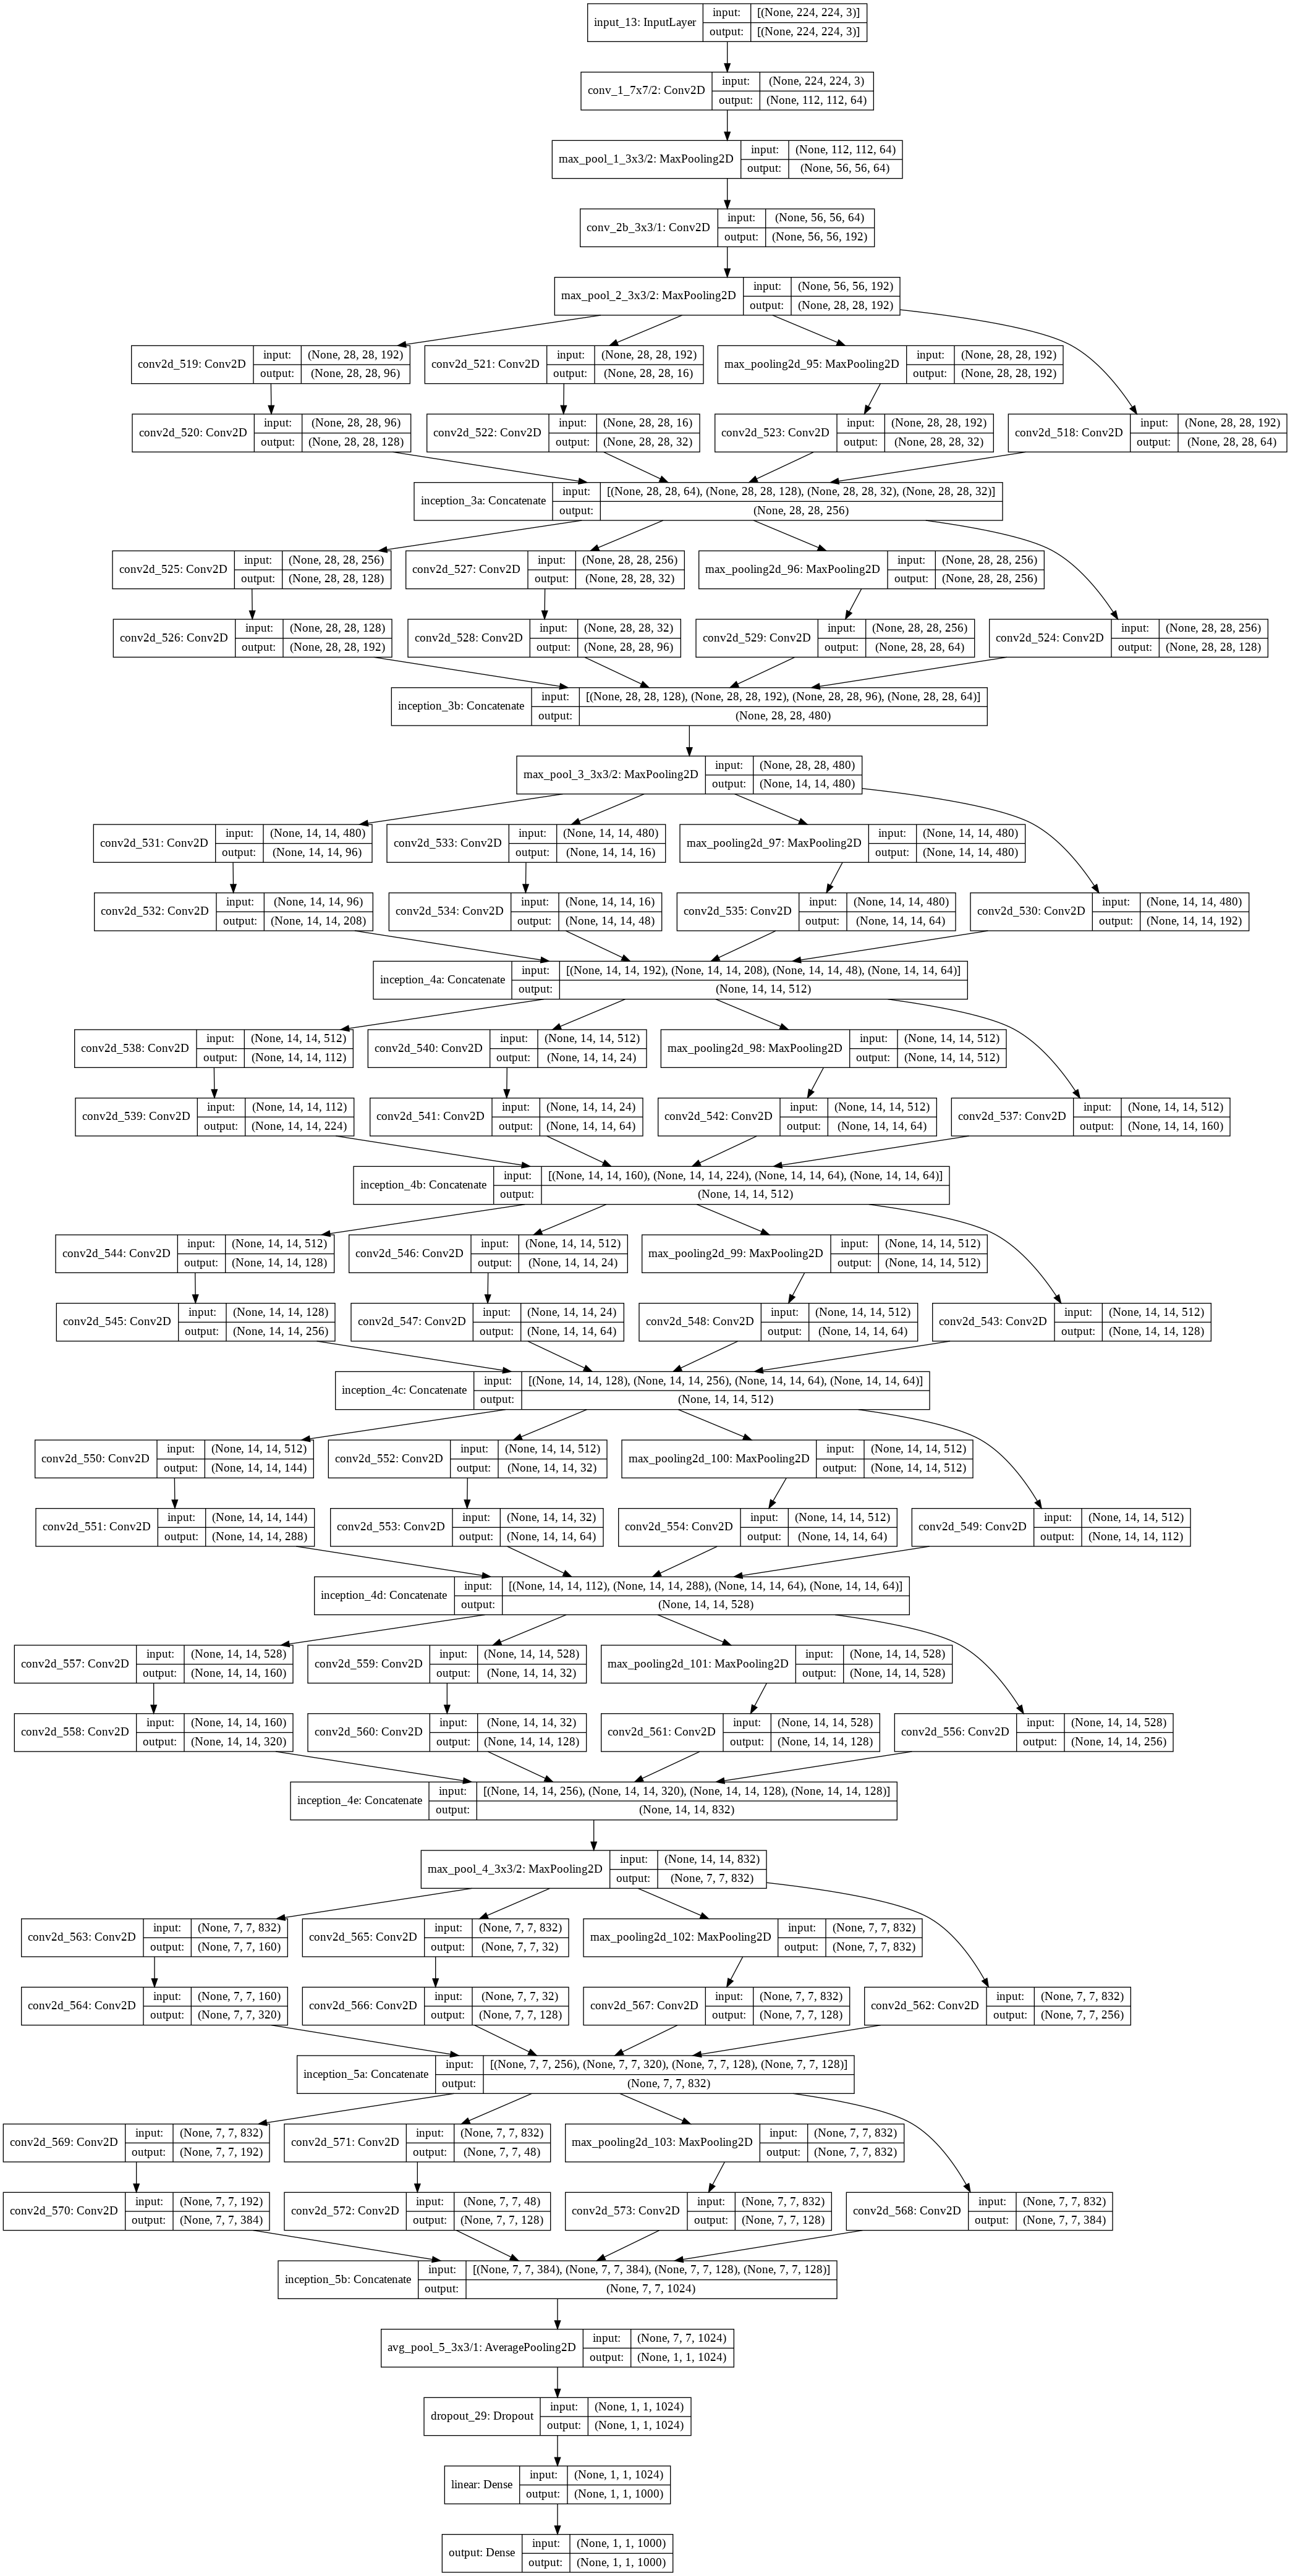

In [179]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [180]:
model_with_classifiers = Model(input_layer, [x, classifier_1, classifier_2], name='googlenet_complete_architecture')
model_with_classifiers.summary()

Model: "googlenet_complete_architecture"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_13[0][0]                   
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2b_3x3/1 (Conv2D)          (None, 56, 56, 192)  110784      max_pool_1_3x3/2[0][0]           
____________________________________________________________________

In [181]:
# Learning Rate:
epochs = 25
initial_learning_rate = 0.01

learning_rate_scheduler = LearningRateScheduler(decay,verbose=1)

sgd = SGD(learning_rate=initial_learning_rate,momentum=0.9,nesterov=False)


In [182]:
# Compile Model:
model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])

In [183]:
history = model.fit(datagen.flow(x_train,y_train,batch_size=32),epochs=32,verbose=2,callbacks=[learning_rate_scheduler],validation_data=(x_valid,y_valid),steps_per_epoch=x_train.shape[0]//32)

Epoch 1/32

Epoch 00001: LearningRateScheduler reducing learning rate to 0.008847359999999999.


ValueError: ignored